# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [1]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [2]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/christian/AIML25/mas/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [3]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate 
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [4]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = mps


### 2. Load data

In [5]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [6]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [7]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 1


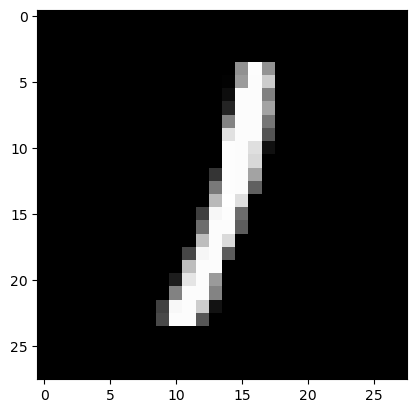

In [8]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [9]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()

    # TODO: define layers
    self.fc1 = nn.Linear(28*28, 500) # Why is it 28*28? Because the image is 28x28 pixels. Why is it 500? Because it's a hyperparameter, it is just an arbitrary number
    self.fc2 = nn.Linear(500, 10) # Why is it 10? Because you output numbers 0 to 9
    self.relu = nn.ReLU()
  
  def forward(self, x : torch.Tensor):

    # TODO: define forward pass
    x = self.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### 5. Training hyperparameters

In [18]:
LR = 0.01  # TODO: define the learning rate. What does the learning rate do? It determines how much the model will change in response to the estimated error each time the model weights are updated
NUM_EPOCHS = 30 # TODO: define the number of epochs (i.e. passes over the dataset). An epoch in this context is a full iteration over the dataset
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [19]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [20]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)

### 6. Training

In [21]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/30]: Train Loss: 1.3132 | Train Accuracy: 74.27% | Val Loss: 0.6824 | Val Accuracy: 84.62%
Epoch [2/30]: Train Loss: 0.5362 | Train Accuracy: 87.00% | Val Loss: 0.4653 | Val Accuracy: 87.96%
Epoch [3/30]: Train Loss: 0.4146 | Train Accuracy: 88.97% | Val Loss: 0.4008 | Val Accuracy: 89.06%
Epoch [4/30]: Train Loss: 0.3671 | Train Accuracy: 89.86% | Val Loss: 0.3671 | Val Accuracy: 89.74%
Epoch [5/30]: Train Loss: 0.3396 | Train Accuracy: 90.50% | Val Loss: 0.3462 | Val Accuracy: 90.16%
Epoch [6/30]: Train Loss: 0.3202 | Train Accuracy: 91.01% | Val Loss: 0.3309 | Val Accuracy: 90.60%
Epoch [7/30]: Train Loss: 0.3049 | Train Accuracy: 91.35% | Val Loss: 0.3187 | Val Accuracy: 91.01%
Epoch [8/30]: Train Loss: 0.2919 | Train Accuracy: 91.77% | Val Loss: 0.3069 | Val Accuracy: 91.24%
Epoch [9/30]: Train Loss: 0.2805 | Train Accuracy: 92.03% | Val Loss: 0.2966 | Val Accuracy: 91.62%
Epoch [10/30]: Train Loss: 0.2703 | Train Accuracy: 92.43% | Val Loss: 0.2882 | Val Accuracy: 91.74%

### 7. Plot loss and accuracy

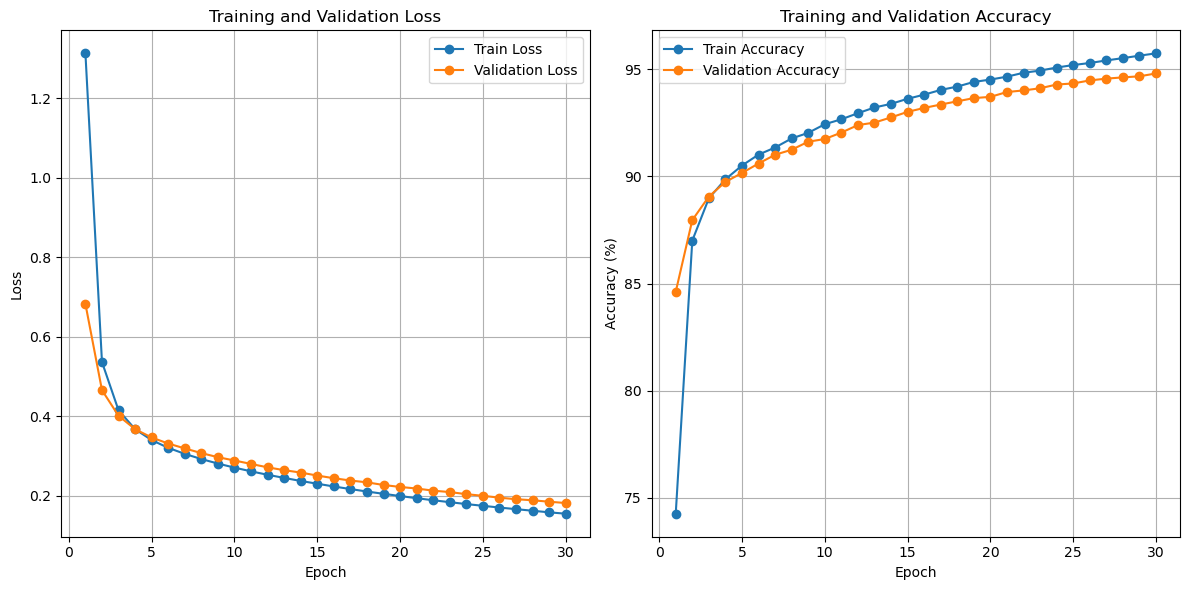

In [22]:
plot_training_history(history)

### 8. Evaluate

In [23]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1522, Accuracy: 95.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4735
           1       0.96      0.99      0.97      5383
           2       0.96      0.95      0.96      4762
           3       0.95      0.95      0.95      4886
           4       0.96      0.95      0.95      4681
           5       0.96      0.93      0.95      4368
           6       0.96      0.98      0.97      4752
           7       0.96      0.97      0.96      4983
           8       0.95      0.93      0.94      4674
           9       0.93      0.95      0.94      4776

    accuracy                           0.96     48000
   macro avg       0.96      0.96      0.96     48000
weighted avg       0.96      0.96      0.96     48000



In [24]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1812, Accuracy: 94.80%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1188
           1       0.97      0.98      0.97      1359
           2       0.95      0.93      0.94      1196
           3       0.93      0.94      0.93      1245
           4       0.94      0.94      0.94      1161
           5       0.95      0.94      0.94      1053
           6       0.96      0.97      0.96      1166
           7       0.95      0.97      0.96      1282
           8       0.95      0.94      0.95      1177
           9       0.92      0.91      0.92      1173

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [25]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1610, Accuracy: 95.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.92      0.96      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.91      0.94       892
           6       0.95      0.97      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.95      0.93      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

